### Preliminaries

In [1]:
import os, sys
import torch
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K


print("Current directory is: ", os.getcwd())
homedir = "../"
datadir = "../data/facescrub/"
sys.path.append(datadir)

from datasets import split_dataset, FaceScrubDataset # causing kernel crash
from models import Pytorch_ANN, Keras_ANN, make_path, train_pytorch_model
from sklearn.model_selection import train_test_split

# Checking to see if GPU is available
print("GPU is available: ", torch.cuda.is_available())

2022-11-28 15:45:44.662026: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Current directory is:  /home/pouya/ACADEMICS/2022_Fall/COMP_541_Deep_Learning/src/comp541-hw/assignment2/2-TL
GPU is available:  True


### Data Extraction

In [2]:
actors_file = os.path.join(datadir, "new_subset_actors.txt")
actresses_file = os.path.join(datadir, "new_subset_actresses.txt")
target_folder = os.path.join(datadir, "uncropped/")

In [13]:
### Construct necessary datasets

# Some constants
img_size = 28
input_size = img_size * img_size * 3
output_size = 40
trainsize = 70
ready_data = os.path.join(datadir, "data_size_28_training_70.parquet")

# Transformations
def transform(img):
    img = (img/255.0).to(torch.float32)
    # img = torch.flatten(img)
    return img


In [14]:
# Construct master dataset
master_dataset = FaceScrubDataset(
    actors_file=actors_file, actresses_file=actresses_file, target_image_size=img_size, 
    target_folder=target_folder, transform=transform, train_size=trainsize, get_data_at_first_call=False,
    delete_image_after_download=True, verbose=False)

/home/pouya/anaconda3/envs/comp541/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  """


In [ ]:
output_size = len(master_dataset.artists_list)
master_dataset.load_data(ready_data)

# Construct training and testing datasets
train_dataset, test_dataset = split_dataset(master_dataset)

In [ ]:
print("Total number of datapoints discovered: ", len(master_dataset))
print("Shape of the dataframe: ", master_dataset.df.shape)
print("Total number of artists discovered: ", output_size)
print("Number of training datapoints: ", len(train_dataset))
print("Number of testing datapoints: ", len(test_dataset))

### Training MLP with PyTorch

In [6]:
# Define hyperparameters
hparams = {
        "model_name": "pytorch_ann",
        "input_size": input_size,
        "output_size": output_size,
        "width": 300,
        "depth": 1,
        "hidden_activation": "relu",
        "output_activation": None,
        "batchnorm": "before",
        "batchnorm_params": None,
        "dropout": 0.2,
        "learning_rate": 0.001,
        "learning_rate_decay_gamma": 0.9,
        "optimizer": "adam",
        "optimizer_params": None,
        "batch_size": 512,
        "epochs": 200,
        "validation_data": 0.1,
        "validation_tolerance_epochs": 200,
        "l2_reg": 0.03,
        "loss_function": "categorical_crossentropy",
        "metrics":['accuracy'],
        "loss_function_params": None,
        "checkpoint_path": None
}

In [ ]:
# Construct ANN model
model = Pytorch_ANN(hparams)
print(model)

In [ ]:
# Train model
model.train_model(train_dataset, verbose=True, script_before_save=False, 
                  saveto=make_path(os.path.join(homedir,"models","Pytorch_ANN.pt")), num_workers=0)

In [ ]:
# Plot model history
epochs = range(1, len(model.history["training_loss"])+1)
training_losses = model.history["training_loss"]
validation_losses = model.history["validation_loss"]
training_accuracies = model.history["training_metrics"]
validation_accuracies = model.history["validation_metrics"]
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(epochs, training_losses, label="Training")
plt.plot(epochs, validation_losses, label="Validation")
plt.title("Loss")
# plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2,1,2)
plt.grid(True)
plt.plot(epochs, training_accuracies, label="Training")
plt.plot(epochs, validation_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(datadir, "pytorch_ann_history_01.png"), dpi=600)

### Using AlexNet as a Frozen Feature Extractor

In [15]:
# Constructing data with 224 pixels rather than 28.
# Dataset object is the same. We will only change its target_image_size property.
# We do not need to download and save all the images, because our dataset is alrewady processed, 
# and we know which URLs are available to use. We can more easily use direct indexing in pytorch dataset.

# Setting some parameters to avoid direct indexing from arrays in the datasset
master_dataset.target_image_size = 224
master_dataset.data_is_processed = False
master_dataset.get_data_at_first_call = False
master_dataset.images = []
# We will not touch the 'labels' property because that one will not change.
# We will not touch the 'df' property because that one will not change.

In [16]:
master_dataset.load_data(os.path.join(datadir, "data_size_224_training_70"))
print("Shape of images array: ", master_dataset.images.shape)
print("Shape of labels array: ", master_dataset.labels.shape)
print("Shape of dataframe:    ", master_dataset.df.shape)

Shape of images array:  (4963, 224, 224, 3)
Shape of labels array:  (4963,)
Shape of dataframe:     (4963, 13)


In [17]:
print("Minimum of the images array: ", master_dataset.images.min())
print("Maximum of the images array: ", master_dataset.images.max())

Minimum of the images array:  0
Maximum of the images array:  255


In [18]:
# Load AlexNet Model
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /home/pouya/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
class TransferFeatures(torch.nn.Module):
    def __init__(self, original_model, classifier, model_name):
        super(TransferFeatures, self).__init__()

        self.features = original_model.features
        # print(self.features)
        self.classifier = classifier
        self.modelName = model_name

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y

classifier = torch.nn.Sequential(
    torch.nn.Linear(256 * 6 * 6, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, output_size)
)

refit_model = TransferFeatures(model, classifier, "alexnet")

In [20]:
# Construct training and testing datasets
train_dataset, test_dataset = split_dataset(master_dataset)

history = train_pytorch_model(refit_model, [train_dataset, test_dataset], batch_size=hparams['batch_size'], 
    loss_str=hparams['loss_function'], optimizer_str=hparams['optimizer'], 
    optimizer_params={'weight_decay':hparams['l2_reg']}, loss_function_params=None, learnrate=hparams['learning_rate'], 
    learnrate_decay_gamma=hparams['learning_rate_decay_gamma'], epochs=hparams['epochs'], 
    validation_patience=10000, validation_data=hparams['validation_data'], 
    verbose=True, script_before_save=False, saveto=os.path.join(homedir,'models','alexnet_refit.pt'), num_workers=0)

Total number of data points:      4963
Number of training data points:   2467
Number of validation data points: 2496
Number of training batches:    5
Number of validation batches:  5
Batch size:                    512
Shape of x_train: torch.Size([512, 3, 224, 224])
Shape of y_train: torch.Size([512])
Shape of x_val: torch.Size([512, 3, 224, 224])
Shape of y_val: torch.Size([512])
selected device:  cuda:0
The learning rate has an exponential decay rate of 0.90000.
Classification problem detected. We will look at accuracies.

First epoch ...

Training phase ...
Shape of class_predictions:  torch.Size([512])
Shape of targets:            torch.Size([512])
Number of correct answers (this batch/total):     4/    4
Number of correct answers (this batch/total):    28/   32
Number of correct answers (this batch/total):    36/   68
Number of correct answers (this batch/total):    46/  114
Number of correct answers (this batch/total):    13/  127
Epoch loss (training): 3.80471
Epoch metric (trai

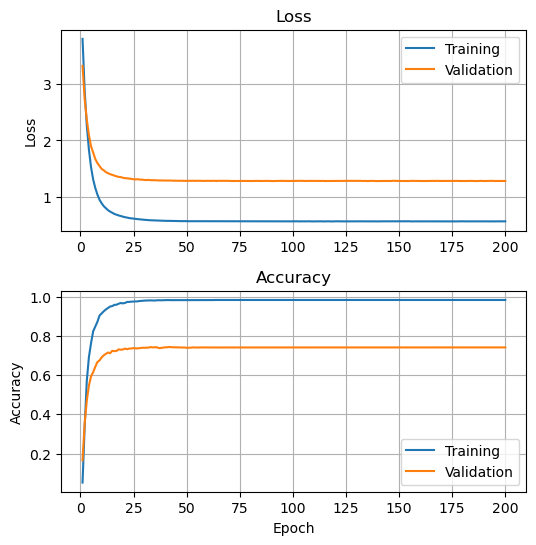

In [21]:
# Plot model history
epochs = range(1, len(history["training_loss"])+1)
training_losses = history["training_loss"]
validation_losses = history["validation_loss"]
training_accuracies = history["training_metrics"]
validation_accuracies = history["validation_metrics"]
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(epochs, training_losses, label="Training")
plt.plot(epochs, validation_losses, label="Validation")
plt.title("Loss")
# plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2,1,2)
plt.grid(True)
plt.plot(epochs, training_accuracies, label="Training")
plt.plot(epochs, validation_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(datadir, "pytorch_alexnet_history_01.png"), dpi=600)

### Training AlexNet with Modified Classification (Output) Layer

In [25]:
class TransferFeaturesV2(torch.nn.Module):
    def __init__(self, original_model, classifier, model_name):
        super(TransferFeaturesV2, self).__init__()

        self.features = original_model.features
        self.avgpool = original_model.avgpool # (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
        # print(self.features)
        self.classifier = classifier
        self.modelName = model_name

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        f = self.avgpool(f)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y


classifier = torch.nn.Sequential(
    torch.nn.Dropout(),
    torch.nn.Linear(256 * 6 * 6, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(4096, output_size),
)

refit_model_v2 = TransferFeaturesV2(model, classifier, "alexnet2")

In [26]:
history = train_pytorch_model(refit_model_v2, [train_dataset, test_dataset], batch_size=hparams['batch_size'], 
    loss_str=hparams['loss_function'], optimizer_str=hparams['optimizer'], 
    optimizer_params={'weight_decay':hparams['l2_reg']}, loss_function_params=None, learnrate=hparams['learning_rate'], 
    learnrate_decay_gamma=hparams['learning_rate_decay_gamma'], epochs=hparams['epochs'], 
    validation_patience=10000, validation_data=hparams['validation_data'], 
    verbose=True, script_before_save=False, saveto=os.path.join(homedir,'models','alexnet_refit_2.pt'), num_workers=0)

Total number of data points:      4963
Number of training data points:   2467
Number of validation data points: 2496
Number of training batches:    5
Number of validation batches:  5
Batch size:                    512
Shape of x_train: torch.Size([512, 3, 224, 224])
Shape of y_train: torch.Size([512])
Shape of x_val: torch.Size([512, 3, 224, 224])
Shape of y_val: torch.Size([512])
selected device:  cuda:0
The learning rate has an exponential decay rate of 0.90000.
Classification problem detected. We will look at accuracies.

First epoch ...

Training phase ...
Shape of class_predictions:  torch.Size([512])
Shape of targets:            torch.Size([512])
Number of correct answers (this batch/total):    17/   17
Number of correct answers (this batch/total):    13/   30
Number of correct answers (this batch/total):    12/   42
Number of correct answers (this batch/total):    19/   61
Number of correct answers (this batch/total):    13/   74
Epoch loss (training): 4.54497
Epoch metric (trai

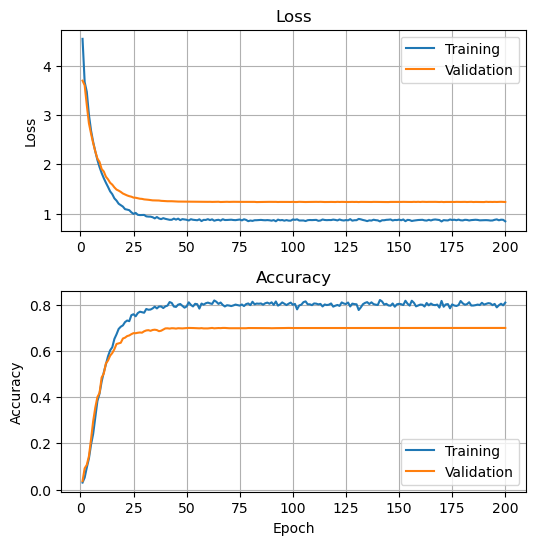

In [27]:
# Plot model history
epochs = range(1, len(history["training_loss"])+1)
training_losses = history["training_loss"]
validation_losses = history["validation_loss"]
training_accuracies = history["training_metrics"]
validation_accuracies = history["validation_metrics"]
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(epochs, training_losses, label="Training")
plt.plot(epochs, validation_losses, label="Validation")
plt.title("Loss")
# plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2,1,2)
plt.grid(True)
plt.plot(epochs, training_accuracies, label="Training")
plt.plot(epochs, validation_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(datadir, "pytorch_alexnet_history_02.png"), dpi=600)

### Training MLP with Keras

In [ ]:
print(tf.config.list_physical_devices('GPU'))

In [ ]:
print("Shape of images: ", master_dataset.images.shape)
print("Shape of labels: ", master_dataset.labels.shape)

In [ ]:
hparams_keras = {
    "model_name": "keras_ann",
    "input_size": input_size,
    "output_size": output_size,
    "width": 300,
    "depth": 1,
    "hidden_activation": "relu",
    "output_activation": "softmax",
    "batchnorm": "before",
    "batchnorm_params": None,
    "dropout": 0.3,
    "learning_rate": 0.001,
    "learning_rate_decay_gamma": 0.9,
    "optimizer": "adam",
    "optimizer_params": None,
    "batch_size": 512,
    "epochs": 200,
    "validation_data": 0.1,
    "validation_tolerance_epochs": 200,
    "l2_reg": 0.03,
    "loss_function": "sparse_categorical_crossentropy",
    "metrics":['accuracy'],
    "loss_function_params": None,
    "checkpoint_path": None
}

In [ ]:
kmodel = Keras_ANN(hparams_keras)
kmodel.net.summary()

In [ ]:
x_all = master_dataset.images
y_all = master_dataset.labels.reshape(-1,1)

num_images = x_all.shape[0]
x_all = (x_all.reshape(num_images, -1)/255.0).astype(np.float32)


x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1, random_state=42, shuffle=True)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

In [ ]:
kmodel.train(x_train, x_test, y_train, y_test, saveto=os.path.join(homedir,'models','Keras_ANN'), verbose=False)

In [ ]:
# Plot model history
epochs = range(1, len(kmodel.history.history["loss"])+1)
training_losses = kmodel.history.history["loss"]
validation_losses = kmodel.history.history["val_loss"]
training_accuracies = kmodel.history.history["accuracy"]
validation_accuracies = kmodel.history.history["val_accuracy"]
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(epochs, training_losses, label="Training")
plt.plot(epochs, validation_losses, label="Validation")
plt.title("Loss")
# plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2,1,2)
plt.grid(True)
plt.plot(epochs, training_accuracies, label="Training")
plt.plot(epochs, validation_accuracies, label="Validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.savefig(os.path.join(datadir, "keras_ann_history_02.png"), dpi=600)

print("Final training accuracy: ", training_accuracies[-1])
print("Final validation accuracy: ", validation_accuracies[-1])

### Visualizing Weights from Keras-Trained Model

In [ ]:
kmodel = tf.keras.models.load_model(os.path.join(homedir,'models','Keras_ANN'))

In [ ]:
kmodel.net.layers

In [ ]:
# Visualizing the outputs of the first layer
partial_model = tf.keras.models.Model(inputs=kmodel.net.input, outputs=kmodel.net.layers[3].output)
x = x_train[0].reshape(1,-1)
output_test = partial_model(x, training=False)
print(output_test.shape)

In [ ]:
def visualize_neurons(network, input_idx, n1_idx, n2_idx):
    '''Visualize the outputs of two neurons in the first hidden layer.
    input_idx is the index of the input from the training dataset.
    n1_idx iod the index of the first neuron.
    n2_idx is the index of the second neuron.
    '''
    weights = network.net.layers[1].get_weights()[0] # 2352 x 300
    w1 = weights[:,n1_idx].reshape(28,28,3) 
    w2 = weights[:,n2_idx].reshape(28,28,3)
    x = x_train[input_idx].reshape(28,28,3)
    y = int(y_train[input_idx][0])
    print("y for this input is: ", y)
    y = master_dataset.artists_list[y]
    a1 = w1 * x
    a2 = w2 * x
    mins = np.min([np.min(a1), np.min(a2)])
    maxs = np.max([np.max(a1), np.max(a2)])
    minw = np.min([np.min(w1), np.min(w2)])
    maxw = np.max([np.max(w1), np.max(w2)])
    a1n = (a1 - mins)/(maxs - mins)
    a2n = (a2 - mins)/(maxs - mins)
    w1n = (w1 - minw)/(maxw - minw)
    w2n = (w2 - minw)/(maxw - minw)
    print("Range of a1 after normalization: ", np.min(a1n), np.max(a1n))
    print("Range of a2 after normalization: ", np.min(a2n), np.max(a2n))
    print("Range of w1 after normalization: ", np.min(w1n), np.max(w1n))
    print("Range of w2 after normalization: ", np.min(w2n), np.max(w2n))
    print("Range of x: ", np.min(x), np.max(x))
    plt.figure(figsize=(10,6))
    plt.suptitle("Sample weight visualization for artist: {}".format(y))
    plt.subplot(2,3,1)
    plt.imshow(x)
    plt.title("Input image")
    plt.subplot(2,3,2)
    plt.imshow(w1n)
    plt.title("First neuron weights")
    plt.subplot(2,3,3)
    plt.imshow(w2n)
    plt.title("Middle neuron weights")
    plt.subplot(2,3,5)
    plt.imshow(a1n)
    plt.title("First neuron outputs")
    plt.subplot(2,3,6)
    plt.imshow(a2n)
    plt.title("Middle neuron outputs")
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    plt.savefig(os.path.join(datadir, "keras_ann_vis_%d_%d_%d.png"%(input_idx, n1_idx, n2_idx)), dpi=600)


visualize_neurons(kmodel, 0, 0, 150)
visualize_neurons(kmodel, 1000, 0, 200)    